# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,  roc_curve, roc_auc_score


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from arch import arch_model
from statsmodels.stats.stattools import durbin_watson

In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)

#YOU DEFINED OPENNING GAPS AS TODAY'S OPEN TO YESTERDAY'S CLOSE INSTEAD OF TODAY'S OPEN TO YESTERDAY'S HIGH/LOW..

data['opening_gaps_2'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)


data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) + ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

# Calculate day change adjusted for opening gap
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']


# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()


# Create lagged features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)

# Create a crossover signal column
data['MA_Crossover_Signal_5_14'] = ((data['MA_5'] > data['MA_14']) & (data['MA_5'].shift(1) <= data['MA_5'].shift(1))).astype(int)
data['MA_Crossover_Signal_today_5'] = ((data['Close/Last'] > data['MA_14']) & (data['Close/Last'].shift(1) <= data['MA_5'].shift(1))).astype(int)


# Create a binary indicator for whether yesterday's close was above or below the 5-day MA
data['yesterday_close_above_MA_5'] = (data['Close/Last'].shift(1) > data['MA_14']).astype(int)


In [6]:
# Shift 'High' and 'Low' columns by 1
data['High_shift'] = data['High'].shift(1)
data['Low_shift'] = data['Low'].shift(1)

# Define the opening gap with the condition
def calculate_opening_gaps(row):
    if row['Open'] > row['High_shift']:
        return (row['Open'] - row['High_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    elif row['Open'] < row['Low_shift']:
        return (row['Open'] - row['Low_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    else:
        return np.nan



# Apply the calculation function to each row
data['opening_gaps_2'] = data.apply(calculate_opening_gaps, axis=1)

# Drop the shifted columns if they're not needed
data.drop(columns=['High_shift', 'Low_shift'], inplace=True)

print(data[['Date', 'Open', 'High', 'Low', 'Close/Last', 'opening_gaps_2']])


           Date    Open     High     Low  Close/Last  opening_gaps_2
2515 2014-09-15  199.16  199.320  198.38     198.981             NaN
2514 2014-09-16  198.61  200.840  198.50     200.480             NaN
2513 2014-09-17  200.77  201.680  199.75     200.750             NaN
2512 2014-09-18  201.36  201.850  201.10     201.820             NaN
2511 2014-09-19  201.52  201.899  200.29     200.700             NaN
...         ...     ...      ...     ...         ...             ...
4    2024-09-06  549.94  551.600  539.44     540.360             NaN
3    2024-09-09  544.65  547.710  542.68     546.410             NaN
2    2024-09-10  548.36  549.150  543.38     548.790        0.001185
1    2024-09-11  548.70  555.360  539.96     554.420             NaN
0    2024-09-12  555.01  559.400  552.74     559.090             NaN

[2516 rows x 6 columns]


## <a id="section2"></a> Moving Averages: Today's Price Change

In [7]:
# Drop rows with NaN values in the columns of interest and explicitly make a copy
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'day_change']).copy()

# Logistic regression preparation: Convert 'day_change' to binary (0 for Down, 1 for Up)
clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Independent variables (three moving averages) and dependent variable (day_change)
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the logistic regression results, including confidence intervals
print(result.summary())

# Extract confidence intervals and rename columns for clarity
conf = result.conf_int()
conf.columns = ['Lower Bound for 95% Interval', 'Upper Bound for 95% Interval']

# Exponentiate coefficients to get odds ratios
conf['Odds Ratio'] = np.exp(result.params)

# Calculate the lower and upper bounds for the odds ratios
conf['Odds Ratio Lower Bound'] = np.exp(conf['Lower Bound for 95% Interval'])
conf['Odds Ratio Upper Bound'] = np.exp(conf['Upper Bound for 95% Interval'])

# Display the confidence intervals and odds ratios
print(conf)

# Calculate probabilities from odds ratios
odds_ratios = np.exp(result.params)
probabilities = odds_ratios / (1 + odds_ratios)

# Calculate the lower and upper bounds for the probabilities
prob_lower_bound = conf['Odds Ratio Lower Bound'] / (1 + conf['Odds Ratio Lower Bound'])
prob_upper_bound = conf['Odds Ratio Upper Bound'] / (1 + conf['Odds Ratio Upper Bound'])

# Display the probabilities and their confidence intervals
prob_conf = pd.DataFrame({
    'Probability': probabilities,
    'Lower Bound for 95% Interval': prob_lower_bound,
    'Upper Bound for 95% Interval': prob_upper_bound
})

print("\nProbabilities with Confidence Intervals:")
print(prob_conf)


print('''
Opening Above the 5-Day Moving Average: If the opening price is above the 5-day moving average, there is a 65.7% chance (or approximately 66% chance) 
that the next day's price movement will be positive. The pseudo-R^2 is only 2% however
''')

print(''' do not run these moving averages as three logistic regressions with a single variable because they will all appear significant and you will
have to dissec tthem to undo the multicollinearity''')

Optimization terminated successfully.
         Current function value: 0.675795
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             day_change   No. Observations:                 2515
Model:                          Logit   Df Residuals:                     2511
Method:                           MLE   Df Model:                            3
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                 0.01996
Time:                        16:29:17   Log-Likelihood:                -1699.6
converged:                       True   LL-Null:                       -1734.2
Covariance Type:            nonrobust   LLR p-value:                 6.265e-15
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2449      0.081     -3.030      0.002      -0.403      -0.086
open_above_

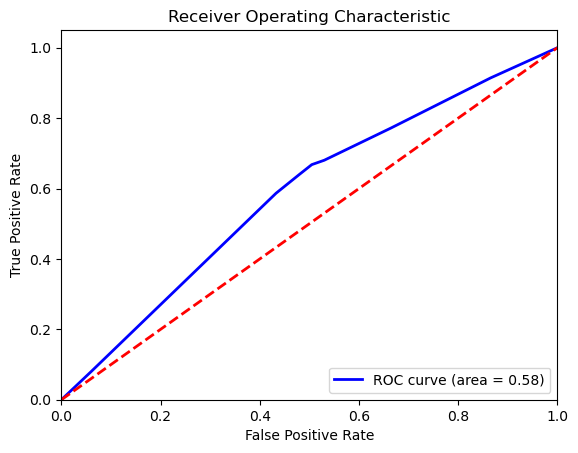

In [8]:
# Predicted probabilities
y_pred_prob = result.predict(X)

# ROC curve
fpr, tpr, _ = roc_curve(y, y_pred_prob)
roc_auc = roc_auc_score(y, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


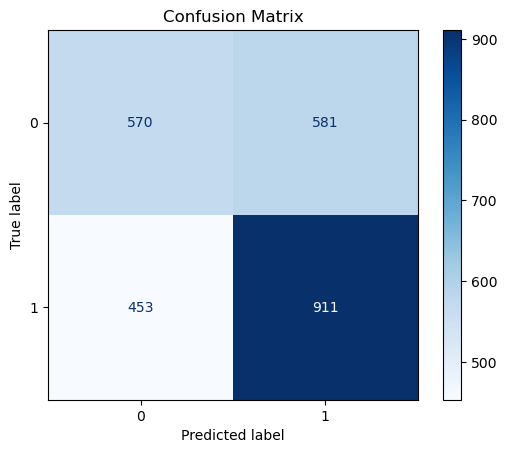

In [9]:
# Predicted class labels
y_pred = (y_pred_prob >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


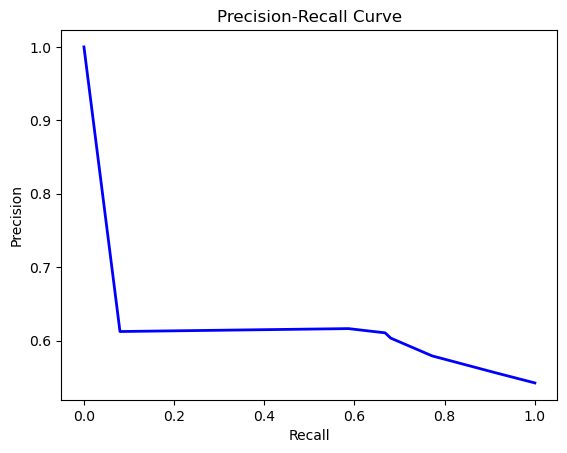

In [10]:
# Precision-recall curve
precision, recall, _ = precision_recall_curve(y, y_pred_prob)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [12]:
# Create the 200-day moving average column
data['MA_200'] = data['Open'].rolling(window=200).mean()

# Create lagged feature comparing today's open to the 200-day moving average
data['open_above_MA_200'] = (data['Open'] > data['MA_200']).astype(int)

# Drop rows with NaN values in the columns of interest and explicitly make a copy
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'open_above_MA_200', 'day_change']).copy()

# Logistic regression preparation: Convert 'day_change' to binary (0 for Down, 1 for Up)
clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Independent variables (including the new 200-day moving average) and dependent variable (day_change)
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'open_above_MA_200']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the logistic regression results, including confidence intervals
print(result.summary())

# Extract confidence intervals and rename columns for clarity
conf = result.conf_int()
conf.columns = ['Lower Bound for 95% Interval', 'Upper Bound for 95% Interval']

# Exponentiate coefficients to get odds ratios
conf['Odds Ratio'] = np.exp(result.params)

# Calculate the lower and upper bounds for the odds ratios
conf['Odds Ratio Lower Bound'] = np.exp(conf['Lower Bound for 95% Interval'])
conf['Odds Ratio Upper Bound'] = np.exp(conf['Upper Bound for 95% Interval'])

# Display the confidence intervals and odds ratios
print(conf)

# Calculate probabilities from odds ratios
odds_ratios = np.exp(result.params)
probabilities = odds_ratios / (1 + odds_ratios)

# Calculate the lower and upper bounds for the probabilities
prob_lower_bound = conf['Odds Ratio Lower Bound'] / (1 + conf['Odds Ratio Lower Bound'])
prob_upper_bound = conf['Odds Ratio Upper Bound'] / (1 + conf['Odds Ratio Upper Bound'])

# Display the probabilities and their confidence intervals
prob_conf = pd.DataFrame({
    'Probability': probabilities,
    'Lower Bound for 95% Interval': prob_lower_bound,
    'Upper Bound for 95% Interval': prob_upper_bound
})

print("\nProbabilities with Confidence Intervals:")
print(prob_conf)


Optimization terminated successfully.
         Current function value: 0.675303
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             day_change   No. Observations:                 2515
Model:                          Logit   Df Residuals:                     2510
Method:                           MLE   Df Model:                            4
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                 0.02067
Time:                        16:29:17   Log-Likelihood:                -1698.4
converged:                       True   LL-Null:                       -1734.2
Covariance Type:            nonrobust   LLR p-value:                 9.954e-15
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3147      0.092     -3.409      0.001      -0.496      -0.134
open_abo

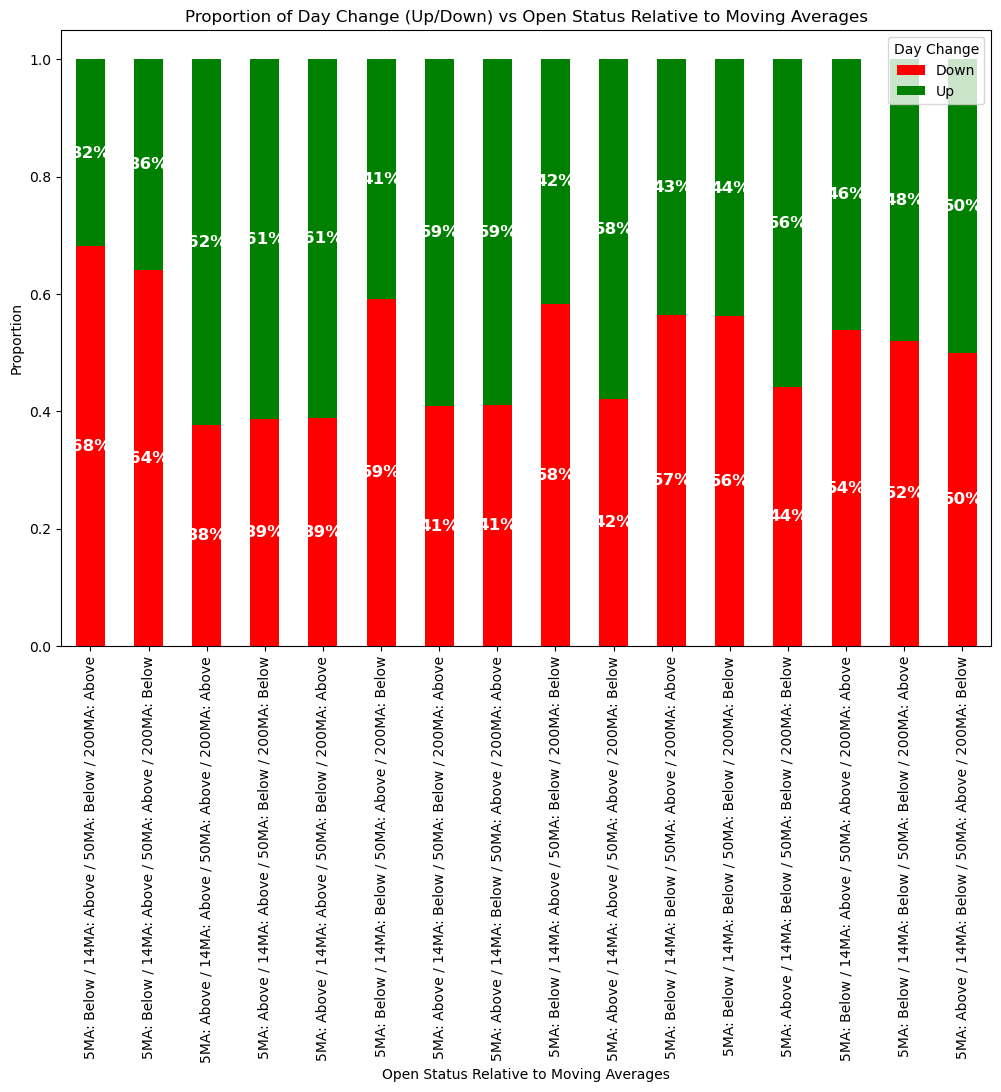

In [28]:
# Create new columns for visualization
clean_data['combined_label'] = clean_data.apply(
    lambda row: f"5MA: {'Above' if row['open_above_MA_5'] else 'Below'} / "
                f"14MA: {'Above' if row['open_above_MA_14'] else 'Below'} / "
                f"50MA: {'Above' if row['open_above_MA_50'] else 'Below'} / "
                f"200MA: {'Above' if row['open_above_MA_200'] else 'Below'}", axis=1)
clean_data['day_change_label'] = clean_data['day_change'].apply(lambda x: 'Up' if x == 1 else 'Down')

# Count the occurrences of each combination of combined_label and 'day_change_label'
counts = clean_data.groupby(['combined_label', 'day_change_label']).size().unstack().fillna(0)

# Normalize the counts to get proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# Calculate the absolute difference between 'Up' and 'Down' proportions for sorting
proportions['Difference'] = abs(proportions['Up'] - proportions['Down'])
proportions = proportions.sort_values('Difference', ascending=False).drop(columns='Difference')

# Create the stacked bar chart
ax = proportions.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(12, 8))

# Add percentages on top of the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.0%}', (x + width / 2, y + height / 2), ha='center', va='center', color='white', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel('Open Status Relative to Moving Averages')
plt.ylabel('Proportion')
plt.title('Proportion of Day Change (Up/Down) vs Open Status Relative to Moving Averages')

# Add legend
plt.legend(title='Day Change')

# Show the plot
plt.show()


In [13]:
# Loop over each moving average period from 1 to 50 days
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    data[ma_column] = data['Open'].rolling(window=i).mean()

# Calculate the binary variables to check if the opening price is above the moving averages
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    data[ma_column] = (data['Open'] > data[ma_column]).astype(int)

# Drop rows with NaN values in the newly created columns
columns_of_interest = [f'open_above_MA_{i}' for i in range(1, 51)]
data.dropna(subset=columns_of_interest, inplace=True)



In [14]:
# Drop rows with NaN values in the columns of interest and explicitly make a copy
clean_data = data.copy()

# Logistic regression preparation: Convert 'day_change' to binary (0 for Down, 1 for Up)
clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Ensure all columns are numeric
clean_data = clean_data.apply(pd.to_numeric, errors='coerce')

# Convert boolean columns to integers
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        clean_data[ma_column] = clean_data[ma_column].astype(int)

# Drop rows with NaN values in the 'day_change' column and moving average columns
columns_of_interest = ['day_change'] + [f'open_above_MA_{i}' for i in range(1, 51)]
clean_data = clean_data.dropna(subset=columns_of_interest)

# Prepare a list to collect results
results_list = []

# Loop over each moving average from 1 to 50 days
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        X = clean_data[[ma_column]]
        y = clean_data['day_change']
        
        # Add a constant term to the predictor
        X = sm.add_constant(X)
        
        # Fit the logistic regression model
        try:
            model = sm.Logit(y, X)
            result = model.fit(disp=0)  # disp=0 suppresses the output
            
            # Extract coefficient and p-value
            coef = result.params[ma_column]
            p_value = result.pvalues[ma_column]
            
            # Only collect significant results with beta > 0.4
            if p_value < 0.05 and coef > 0.4:
                results_list.append({
                    'Moving Average': i,
                    'Coefficient': coef,
                    'P-Value': p_value
                })
        except np.linalg.LinAlgError as e:
            print(f"Singular matrix error for {ma_column}: {e}")
        except Exception as e:
            print(f"Error fitting model for {ma_column}: {e}")

# Convert results list to a DataFrame
results_summary = pd.DataFrame(results_list)

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)

print("\nSignificant Moving Averages with Coefficients > 0.4:")
print(results_summary_sorted)


Singular matrix error for open_above_MA_1: Singular matrix

Significant Moving Averages with Coefficients > 0.4:
    Moving Average  Coefficient       P-Value
0                2     0.914357  1.306516e-28
1                3     0.783759  1.501753e-21
2                4     0.737372  3.168717e-19
3                5     0.681289  1.279870e-16
4                6     0.639606  8.002875e-15
5                7     0.592777  7.415684e-13
6                8     0.524033  2.204753e-10
8               10     0.493813  2.709581e-09
7                9     0.477810  7.790575e-09
9               11     0.467724  2.024844e-08
10              12     0.463393  2.948047e-08
11              13     0.445060  1.075604e-07
12              14     0.430703  2.767141e-07
15              19     0.428373  4.003185e-07
14              16     0.415150  8.133684e-07
13              15     0.408233  1.215169e-06


Singular matrix error for open_above_MA_1: Singular matrix

Significant Moving Averages with Coefficients > 0.4:
    Moving Average  Coefficient       P-Value  Odds Ratio  Probability  \
0                2     0.914357  1.306516e-28    2.495170     0.713891   
1                3     0.783759  1.501753e-21    2.189687     0.686490   
2                4     0.737372  3.168717e-19    2.090435     0.676421   
3                5     0.681289  1.279870e-16    1.976424     0.664026   
4                6     0.639606  8.002875e-15    1.895734     0.654664   
5                7     0.592777  7.415684e-13    1.809006     0.644002   
6                8     0.524033  2.204753e-10    1.688825     0.628090   
8               10     0.493813  2.709581e-09    1.638552     0.621004   
7                9     0.477810  7.790575e-09    1.612538     0.617231   
9               11     0.467724  2.024844e-08    1.596358     0.614845   
10              12     0.463393  2.948047e-08    1.589457     0.613819   

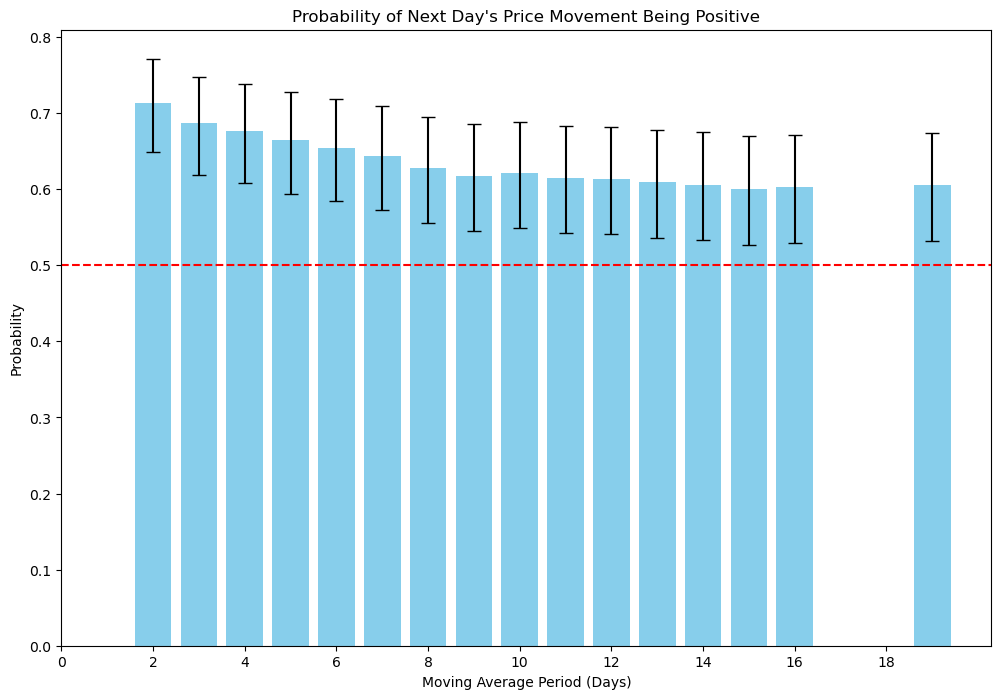


The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages.. say 14 that is not included or already encapsulated in the 5 day.

 
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.


logistic regression assumes independence of both the featuers and dependent variable.



In [24]:
# Drop rows with NaN values in the columns of interest and explicitly make a copy
clean_data = data.copy()

# Logistic regression preparation: Convert 'day_change' to binary (0 for Down, 1 for Up)
clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Ensure all columns are numeric
clean_data = clean_data.apply(pd.to_numeric, errors='coerce')

# Convert boolean columns to integers
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        clean_data[ma_column] = clean_data[ma_column].astype(int)

# Drop rows with NaN values in the 'day_change' column and moving average columns
columns_of_interest = ['day_change'] + [f'open_above_MA_{i}' for i in range(1, 51)]
clean_data = clean_data.dropna(subset=columns_of_interest)

# Prepare a list to collect results
results_list = []

# Loop over each moving average from 1 to 50 days
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        X = clean_data[[ma_column]]
        y = clean_data['day_change']
        
        # Add a constant term to the predictor
        X = sm.add_constant(X)
        
        # Fit the logistic regression model
        try:
            model = sm.Logit(y, X)
            result = model.fit(disp=0)  # disp=0 suppresses the output
            
            # Extract coefficient, p-value, and Durbin-Watson statistic
            coef = result.params[ma_column]
            p_value = result.pvalues[ma_column]
            dw_stat = durbin_watson(result.resid_generalized)
            
            # Only collect significant results with beta > 0.4
            if p_value < 0.05 and coef > 0.4:
                odds_ratio = np.exp(coef)
                prob = odds_ratio / (1 + odds_ratio)
                
                # Collect the results
                results_list.append({
                    'Moving Average': i,
                    'Coefficient': coef,
                    'P-Value': p_value,
                    'Odds Ratio': odds_ratio,
                    'Probability': prob,
                    'Durbin-Watson': dw_stat
                })
        except np.linalg.LinAlgError as e:
            print(f"Singular matrix error for {ma_column}: {e}")
        except Exception as e:
            print(f"Error fitting model for {ma_column}: {e}")

# Convert results list to a DataFrame
results_summary = pd.DataFrame(results_list)

# Calculate confidence intervals for odds ratios and probabilities
results_summary['Odds Ratio Lower Bound'] = np.exp(results_summary['Coefficient'] - 1.96 * results_summary['Coefficient'].std())
results_summary['Odds Ratio Upper Bound'] = np.exp(results_summary['Coefficient'] + 1.96 * results_summary['Coefficient'].std())
results_summary['Probability Lower Bound'] = results_summary['Odds Ratio Lower Bound'] / (1 + results_summary['Odds Ratio Lower Bound'])
results_summary['Probability Upper Bound'] = results_summary['Odds Ratio Upper Bound'] / (1 + results_summary['Odds Ratio Upper Bound'])

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)

# Print the results
print("\nSignificant Moving Averages with Coefficients > 0.4:")
print(results_summary_sorted)

# Plot stacked bar graph of probabilities with confidence intervals
plt.figure(figsize=(12, 8))
plt.bar(results_summary_sorted['Moving Average'], results_summary_sorted['Probability'], yerr=[results_summary_sorted['Probability'] - results_summary_sorted['Probability Lower Bound'], results_summary_sorted['Probability Upper Bound'] - results_summary_sorted['Probability']], capsize=5, color='skyblue')
plt.xlabel('Moving Average Period (Days)')
plt.ylabel('Probability')
plt.title('Probability of Next Day\'s Price Movement Being Positive')
plt.xticks(ticks=np.arange(0, 20, 2), labels=np.arange(0, 20, 2))
plt.axhline(y=0.5, color='red', linestyle='--')
plt.show()


print('''
The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages.. say 14 that is not included or already encapsulated in the 5 day.
''')

print(''' 
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.
''')

print('''
Durbin watson oconirms that there is no autocorrelation
''')


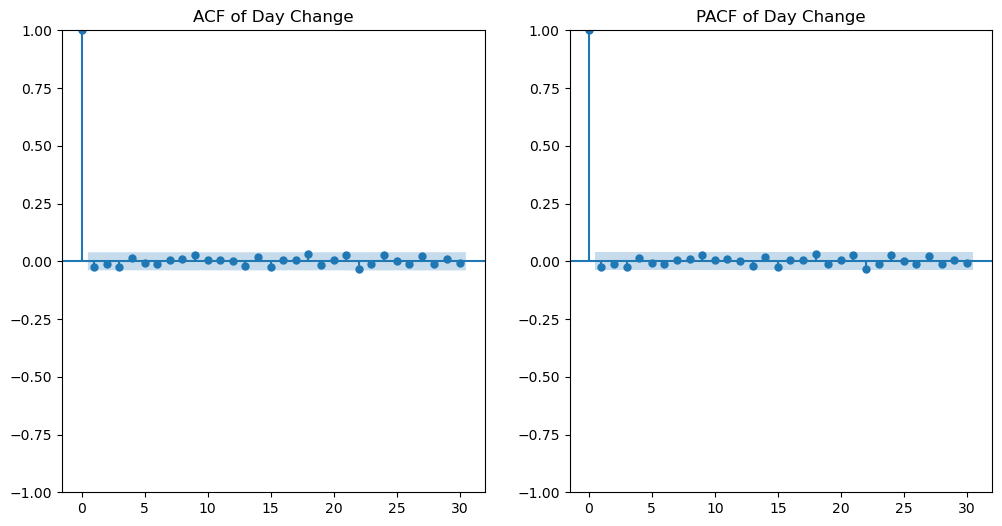

In [25]:
# Plot ACF and PACF for the dependent variable
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(clean_data['day_change'], lags=30, ax=plt.gca())
plt.title('ACF of Day Change')

plt.subplot(122)
plot_pacf(clean_data['day_change'], lags=30, ax=plt.gca())
plt.title('PACF of Day Change')

plt.show()

print('''
the below charts show that there is no temporal dependencies for the dependent vairables with itself
''')


In [16]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'day_change'])

# Independent variables
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50']]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Initialize a DataFrame to hold VIF and R^2 values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculate VIF and R^2 for each variable
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["R_squared"] = [
    sm.OLS(X.iloc[:, i], X.iloc[:, [j for j in range(X.shape[1]) if j != i]]).fit().rsquared for i in range(X.shape[1])
]

print(vif_data)


            feature       VIF  R_squared
0             const  4.024110   0.751498
1   open_above_MA_5  1.472361   0.320819
2  open_above_MA_14  1.820981   0.450846
3  open_above_MA_50  1.334948   0.250907


In [17]:
print('''

Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the 
idea that the data lacks a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum 
over these periods. So, the moving averages are not =trending indicators in this context. What's your next data adventure?

''')



Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the idea that the data lacks 
a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum over these periods. So, the moving averages are not 
trending indicators in this context. What's your next data adventure?




                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.004385
Date:                Tue, 17 Dec 2024   Prob (F-statistic):              0.947
Time:                        16:33:53   Log-Likelihood:                 7578.4
No. Observations:                2467   AIC:                        -1.515e+04
Df Residuals:                    2465   BIC:                        -1.514e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0005      0.001     

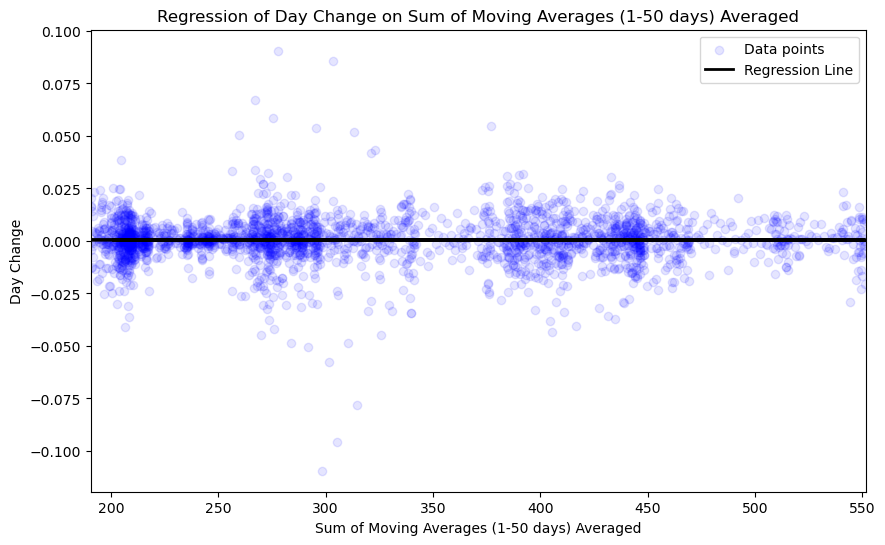



Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.




In [21]:
# Initialize the column to store the sum of moving averages
data['Sum_MA_1_50'] = 0

# Calculate and sum the moving averages from 1 to 50 days
for i in range(1, 51):
    # Calculate the moving average for each window size 'i'
    ma = data['Close/Last'].rolling(window=i).mean()
    # Add the calculated moving average to 'Sum_MA_1_50'
    data['Sum_MA_1_50'] += ma

# Divide by 50 to get the average
data['Sum_MA_1_50_Avg'] = data['Sum_MA_1_50'] / 50

# Ensure 'day_change' is defined
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['Sum_MA_1_50_Avg', 'day_change'])

# Independent variable and dependent variable
X = clean_data[['Sum_MA_1_50_Avg']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['Sum_MA_1_50_Avg'], clean_data['day_change'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(clean_data['Sum_MA_1_50_Avg'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Sum of Moving Averages (1-50 days) Averaged')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Sum of Moving Averages (1-50 days) Averaged')

# Set the x-axis limit to fit the range of 'Sum_MA_1_50_Avg'
plt.xlim(clean_data['Sum_MA_1_50_Avg'].min(), clean_data['Sum_MA_1_50_Avg'].max())

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''

Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.

''')


In [19]:
# Create moving average features
for i in range(1, 51):
    data[f'MA_{i}'] = data['Close/Last'].rolling(window=i).mean()

# Drop NaN values
clean_data = data.dropna()

# Initialize a list to store the results
results = []

# Define the train-test split index based on TIME (THIS KEEPS DATA IN CHRONOLOGICAL ORDER)
train_size = int(0.8 * len(clean_data))
train, test = clean_data.iloc[:train_size], clean_data.iloc[train_size:]

# Loop through each moving average period
for i in range(1, 51):
    # Define the feature (moving average) and the target (day_change)
    X_train = train[[f'MA_{i}']]
    y_train = train['day_change']
    X_test = test[[f'MA_{i}']]
    y_test = test['day_change']
    
    # Add a constant term for the intercept
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    
    # Fit the OLS model
    ols_model = sm.OLS(y_train, X_train_const).fit()
    
    # Obtain the residuals
    residuals = ols_model.resid
    
    # Rescale the residuals to improve optimizer convergence
    residuals_scaled = residuals * 100
    
    # Fit the GARCH model using the scaled residuals
    garch_model = arch_model(residuals_scaled, vol='Garch', p=1, q=1, reindex=True).fit(disp='off')
    
    # Predict future volatility (for demonstration purposes)
    predictions = garch_model.forecast(horizon=len(X_test), reindex=True)
    predicted_variance = predictions.variance.values[-1, :]
    
    # Calculate error metrics (using the residual variance as a placeholder)
    mse = mean_squared_error(y_test, predicted_variance)
    r2 = r2_score(y_test, predicted_variance)
    
    # Extract model parameters
    params = garch_model.params
    
    # Store the results
    results.append({
        'Moving Average': i,
        'Mean Squared Error': mse,
        'R²': r2,
        'Parameters': params
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Sort the results by R² in descending order
sorted_results_df = results_df.sort_values(by='R²', ascending=False)

# Display the sorted results
print(sorted_results_df)

# Example plotting the first moving average results
ma_example = 1
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['day_change'], label='Actual Returns')
plt.plot(test.index, predicted_variance, label=f'Predicted Variance MA_{ma_example}', color='red')
plt.legend(loc='best')
plt.show()

print('''
By rescaling the residuals and explicitly setting the reindex parameter, the optimizer in the GARCH model should now converge more easily, providing more accurate and reliable parameter estimates and variance predictions.
''')


TypeError: arch_model() got an unexpected keyword argument 'reindex'